# Nitrate Colored Map

In [12]:
# all sorts of packsges. there are some exceptions to deal with later
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs # Pythonic file-system for Google Cloud Storage
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
import os
import shelve
from scipy.interpolate import griddata

# %matplotlib inline

### WOA Data 

In [13]:
filelist = []
filename0 = '/home/jovyan/WOA_Data/woa18_all_n00_01.nc'
    
woa_ds_N = xr.open_mfdataset(filename0, chunks = 'auto', decode_times = False)

woa_no3 = woa_ds_N.n_an

# WOA_N_NP = woa_no3.sel(depth = 0.0).sel(lat=slice(45,50)).sel(lon=slice(30,40)).mean(dim="lon").mean(dim="lat").values
# WOA_N_NA = woa_no3.sel(depth = 0.0).sel(lat=slice(45,50)).sel(lon=slice(145,155)).mean(dim="lon").mean(dim="lat").values
WOA_N_NP = woa_no3.sel(depth = 0.0)
WOA_N_NA = woa_no3.sel(depth = 0.0)



In [3]:
woa_no3.sel(depth = 0.0)

<xarray.DataArray 'n_an' (time: 1, lat: 180, lon: 360)>
dask.array<getitem, shape=(1, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    depth    float32 0.0
  * time     (time) float32 8.214e+03
Attributes:
    standard_name:  moles_concentration_of_nitrate_in_sea_water
    long_name:      Objectively analyzed mean fields for moles_concentration_...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          micromoles_per_kilogram

<ipython-input-4-0437df4dee92>:4: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(cmap = cmap)


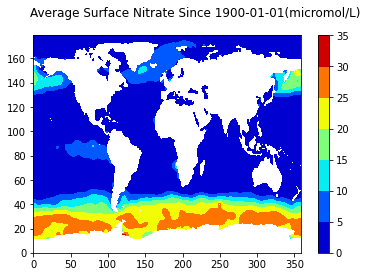

In [4]:
s = woa_no3.sel(depth = 0.0).sel(time = 8214).values
cmap = mpl.cm.jet
p = plt.contourf(s,cmap = cmap)
cb = plt.colorbar(cmap = cmap)

plt.suptitle('Average Surface Nitrate Since 1900-01-01(micromol/L)', fontsize=12)
plt.savefig('/home/jovyan/Quickplots/Mean_NO3_WOA.png', dpi=600,format='png')   # Change Value here

## Adding Fay Mckinley Biomes
filelist = '/home/jovyan/Time_Varying_Biomes.nc'
w = xr.open_mfdataset(filelist, chunks = 'auto', decode_times = False)

In [14]:
filelist = '/home/jovyan/Time_Varying_Biomes.nc'
w = xr.open_mfdataset(filelist, chunks = 'auto', decode_times = False)

<ipython-input-6-2e691a084ed2>:6: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(cmap = cmap)


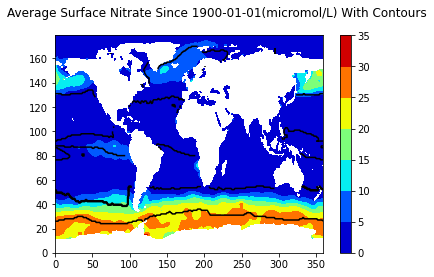

In [6]:
mean = w.MeanBiomes.values
pl1 = plt.contour(mean.transpose(),colors = 'black')
s = woa_no3.sel(depth = 0.0).sel(time = 8214).values
cmap = mpl.cm.jet
pl1 = plt.contourf(s,cmap = cmap)
cb = plt.colorbar(cmap = cmap)

plt.suptitle('Average Surface Nitrate Since 1900-01-01(micromol/L) With Contours', fontsize=12)
plt.savefig('/home/jovyan/Quickplots/Mean_NO3_WOA_WithContours.png', dpi=600,format='png')   # Change Value here

<ipython-input-9-8515d7ab1ebc>:4: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(cmap=cmap)


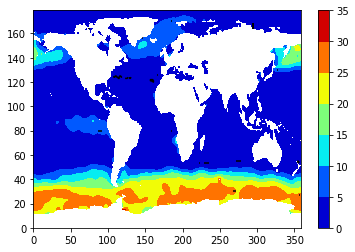

In [9]:
core = w.CoreBiomes.values
pl2 = plt.contour(core.transpose(),colors = 'black')
pl2 = plt.contourf(s,cmap = cmap)
cb = plt.colorbar(cmap=cmap)

## CMIP6 Model Data for NO3 with Biome Separation

In [15]:
# this function pulls the data from the server. it is an algorithm not the calculation 
# also exceptions
def get_data(df, var, model, expe, freq):
    try:
        uri = df[(df.variable_id == var) & \
                 (df.source_id == model) & \
                 (df.experiment_id == expe) & \
                 (df.table_id == freq)].zstore.values[0]
        gcs = gcsfs.GCSFileSystem(token='anon')
        ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    except:
        ds = []
        print(model, ": no data")
    return ds    
   

Fetch the data from 15 models that have biogeochem output.



In [16]:
# regrid method: also an algorythm
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                     'lon': (['lon'], np.arange(0, 361, 1.0)),
                    }
                   )
ds_out

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 361)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    *empty*

In [17]:
# version from Github
# logic: Read a model and pull the var (Surface are with -"os" whichever is available) 

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')


# skip MRi model due to time format. Updated list. sometimes it works. I am confused
models = ['CESM2', 'CESM2-WACCM', 'GFDL-CM4', 'GFDL-ESM4', 'IPSL-CM6A-LR',  
          'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'MIROC-ES2L', 'NorCPM1', 
           'NorESM2-LM', 'MPI-ESM1-2-HR', 'UKESM1-0-LL', 'CNRM-ESM2-1','ACCESS-ESM1-5','MPI-ESM1-2-LR',
            'CanESM5-CanOE','CanESM5','EC-Earth3' ]

# varnames = ['phyc', 'chlos', 'phydiatos', 'intpp','tos']
# var = ['tos']
# var = 'chlmisc'
# var = 'phyc'
# var = 'dfeos'
# var = 'intppdiat'
# var = 'phydiat'
# var = 'epc100'
# var = 'tos'
# var = 'spco2'
# var = 'fgco2'
# var = 'intpp'
# var = 'zpico'
# var = 'rsntds'
# var = 'zooc'
# var = 'no3os'
# var='sios'
expe = 'historical'
freq = 'Omon'

# var2 = 'phyc'
start_time = '1991'
end_time = '2010'
# #seconf set for the end of 100 years
# expe2 = 'ssp585'
# start_time2 = '2081'
# end_time2 = '2082' #2099

var = 'no3'
var2 = var+'os'


xrays = []
# xrays2 = []
new_models = []

for model in models:
    print(model)
    xray = get_data(df, var2, model, expe, freq)
    if model == 'UKESM1-0-LL' or model ==  'CNRM-ESM2-1': 
        xray = get_data(df, var, model, expe, freq) 
    
    
    # if xray is not empty
    if isinstance(xray, xr.Dataset):  
         
#         xray2 = get_data(df, var, model, expe2, freq)
#         if isinstance(xray2, xr.Dataset):
            xrays.append(xray)
        
#             xrays2.append(xray2)
        
            new_models.append(model)
        
xray_dic = {key:value for key, value in zip(new_models, xrays)}
# xray2_dic = {key:value for key, value in zip(new_models, xrays2)}








CESM2
CESM2-WACCM
GFDL-CM4
GFDL-CM4 : no data
GFDL-ESM4
IPSL-CM6A-LR
GISS-E2-1-G
GISS-E2-1-G-CC
MIROC-ES2L
NorCPM1
NorCPM1 : no data
NorESM2-LM
MPI-ESM1-2-HR
UKESM1-0-LL
CNRM-ESM2-1
ACCESS-ESM1-5
MPI-ESM1-2-LR
CanESM5-CanOE
CanESM5
EC-Earth3
EC-Earth3 : no data


In [18]:
%%time

# 
regrids1 = []
# regrids2 = []
# regrids3 = []


for model in new_models:
    print(model)
    vvar = var+'os' 
    if 'latitude' in xray_dic[model].coords:    
        xray_dic[model] = xray_dic[model].rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in xray_dic[model].coords:
        xray_dic[model] = xray_dic[model].rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    if model == 'UKESM1-0-LL' or model ==  'CNRM-ESM2-1': 
        vvar = var 
    
    ds = xray_dic[model].sel(time=slice(start_time, end_time))[vvar].mean(dim='time')
#     ds_end = xray2_dic[model].sel(time=slice(start_time2, end_time2))[var].mean(dim='time')
    
    
    if 'lev_partial' in ds.coords:
        ds = ds.isel(lev_partial=0)
#         ds_end = ds_end.isel(lev_partial=0)
    if 'olevel' in ds.coords:
        ds = ds.isel(olevel=0)
#         ds_end = ds_end.isel(olevel=0)
    if 'lev' in ds.coords:
        ds = ds.isel(lev=0)
#         ds_end = ds_end.isel(lev=0)

    
#     ds_diff = np.subtract(ds, ds_end)     
    dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
        
        
    dsr._grid_in = None
    dsr._grid_out = None
    dsr_out = dsr(ds)
#     dsr_out_end = dsr(ds_end)
#     dsr_out_diff = dsr(ds_diff)

#     dsr.clean_weight_file() # comented, coz regridder has no attribute clean_weight_file()  I guess, coz we do not reuse the weights anywah
# checked by running dsr
    
    
                
    regrids1.append(dsr_out)  # appends a model to a set
#     regrids2.append(dsr_out_end)
#     regrids3.append(dsr_out_diff)
    
#regrid_dic = {key:value for key, value in zip(new_models, regrids1,regrids2,regrids3)}


CESM2


/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not foun

CESM2-WACCM


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; re

GFDL-ESM4


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'bounds_nav_lon'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'bounds_nav_lat'} not found in object but are referred to in the CF attributes.
  warnings.warn(


IPSL-CM6A-LR


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; re

GISS-E2-1-G


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


GISS-E2-1-G-CC


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'x_bnds', 'y_bnds', 'vertices_longitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'x_bnds', 'y_bnds', 'vertices_latitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(


MIROC-ES2L


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_longitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_latitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(


NorESM2-LM


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_longitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_latitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(


MPI-ESM1-2-HR


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_longitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_latitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(


UKESM1-0-LL


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'bounds_lon'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'bounds_lat'} not found in object but are referred to in the CF attributes.
  warnings.warn(


CNRM-ESM2-1


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


ACCESS-ESM1-5


/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_longitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_latitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'

MPI-ESM1-2-LR


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_longitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_latitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(


CanESM5-CanOE


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_longitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_latitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(


CanESM5


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CPU times: user 2min 11s, sys: 16 s, total: 2min 27s
Wall time: 2min 29s


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [ ]:
# checks if the value in the ds is realistic
a = ds.values
np.nanmax(a)

## Regridding

Behzad's code for regridding:

nearest from scipy.interpolate.datagrid
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

Here we use xesmf
https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html


In [19]:
regrid_dic1 = {key:value for key, value in zip(new_models, regrids1)} # start of the priod

In [20]:
# enables libraries for plotting
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import cartopy.crs as ccrs


In [21]:
n=60

maxval = np.amax(regrid_dic1['CESM2'])
minval = np.amin(regrid_dic1['CESM2'])

print(maxval.values)
print(minval.values)
for model in new_models:
    
    temparray = regrid_dic1[model]
    
    maxval = max(maxval, np.amax(temparray))
    minval = min(minval, np.amin(temparray))
    

    
levels = np.linspace(minval, maxval, n+1)


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.021661065660248665


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-7.614088885770215e-05


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.

CESM2


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CESM2-WACCM


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


GFDL-ESM4


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


IPSL-CM6A-LR


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


GISS-E2-1-G
GISS-E2-1-G-CC
MIROC-ES2L


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


NorESM2-LM


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MPI-ESM1-2-HR


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


UKESM1-0-LL


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CNRM-ESM2-1


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


ACCESS-ESM1-5


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MPI-ESM1-2-LR


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CanESM5-CanOE


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CanESM5


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 2min 15s, sys: 56.3 s, total: 3min 11s
Wall time: 1min 32s


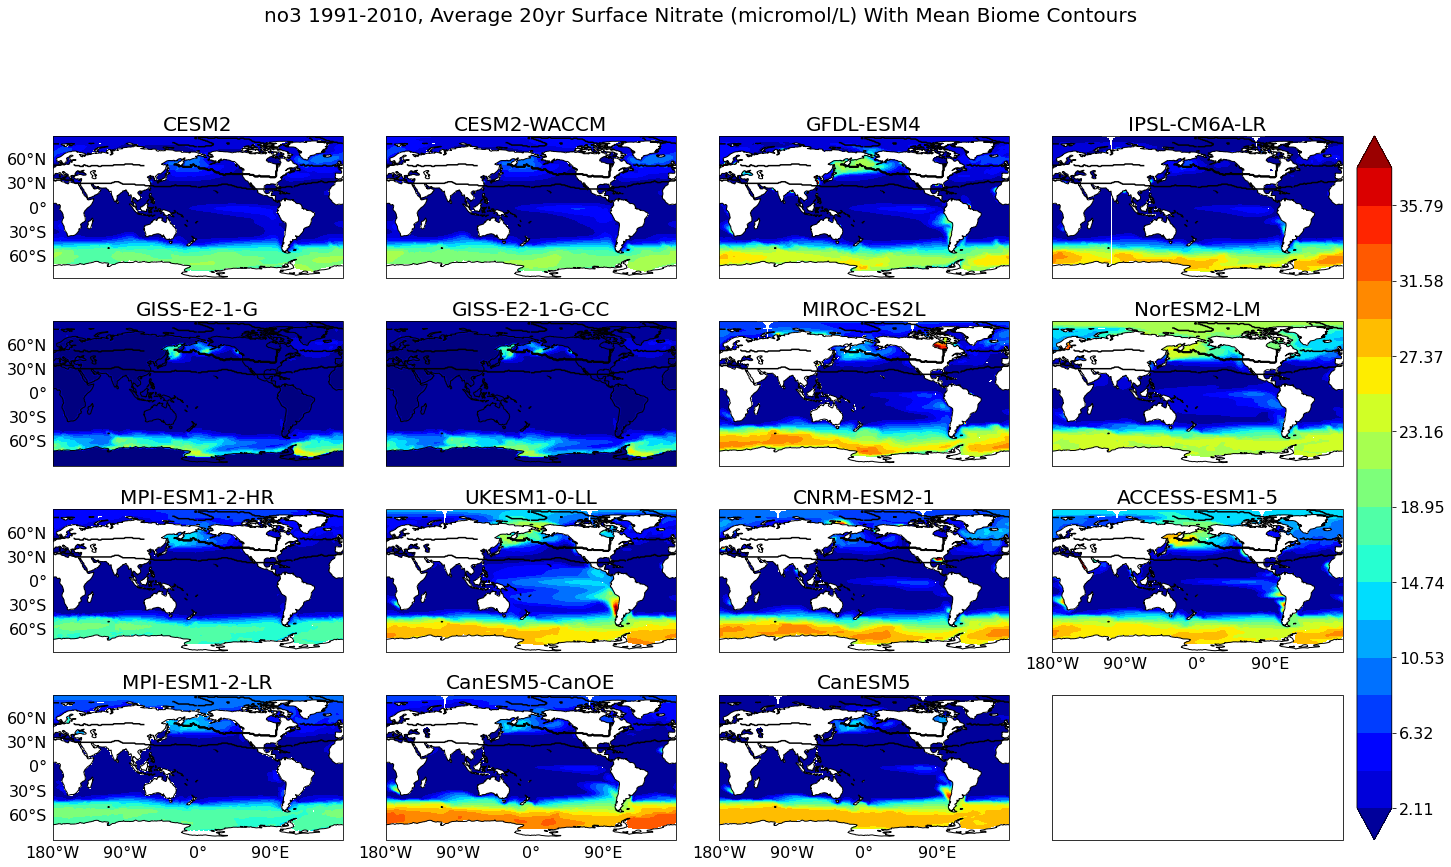

In [23]:
%%time



fig = plt.figure(figsize=(24, 14))

n_c = 4
n_r = 4
n_t=len(new_models)


projection = ccrs.PlateCarree(central_longitude=180)
axes_class = (GeoAxes,dict(map_projection=projection))
axgr = AxesGrid(fig, 111, axes_class=axes_class, nrows_ncols=(n_r, n_c),
                    axes_pad=0.6,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    share_all = False,
                    label_mode='')  # note the empty label_mode

#projection = ccrs.PlateCarree(central_longitude=180)
# levels = np.linspace(-0.001, 0.005, 0.02)
# levels = np.logspace(-0.001, 0.006, 0.02)
# plot_ranges 
# vmin = -0.003
# vmax = 0.003

vmin = 0
vmax = 100
n=60

levels = np.linspace(0,40,20)

# levels = np.logspace(vmin, vmax, n+1,base=10.0)
# levels = np.logspace(vmin, vmax, n+1) # for differences
cmap = mpl.cm.jet
i = 0
A = 2  # A=2 - use data "as is", A
for model in new_models:
    print(model)   
#     if isinstance(xray2_dic[model], list):  #saved this line to not forget it had to be there in other cases
    if A == 3:
        continue # here there might be some condition, for example a scale factor for units conversion
    else:
#         s = regrid_dic_max[model]*12 ## Whatch out for units. mmolC -> mgC = 12; 
        s = regrid_dic1[model] *1000
#         s = s * 12000 # Change value here * 12 to get miligrams/m3 from mol/m3. 
        
        ax = list(axgr)[i]
        i = i + 1
#        # Change Value here for levels or var or transform
        p = ax.contourf(regrid_dic1[model].lon, regrid_dic1[model].lat, s,levels=levels, cmap = cmap, transform=ccrs.PlateCarree(), extend='both')   # Change Value here
        mean = w.MeanBiomes.values
        p = ax.contour(mean.transpose(),colors = 'black')
        ax.coastlines()
        ax.set_title(str(model),fontsize= 20)
    #https://stackoverflow.com/questions/49956355/adding-gridlines-using-cartopy
        gl = ax.gridlines(crs=projection, alpha=0, draw_labels=True)
#         gl.xlabels_top = False
        gl.top_labels = False
        gl.xlocator = mticker.FixedLocator([ 90, 0, -90, -180])
        gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        
        if i-1 == (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot
#             gl.ylabels_left = True
            gl.left_labels = True
            gl.right_labels=False
            gl.ylabel_style = {'size': 16} # labels = [left,right,top,bottom] # Longitudes
            gl.xlines = True
            gl.xlabel_style = {'size': 16}
        elif i-1==0 or i-1==n_c or i-1==n_c*2 or i-1==n_c*3 or i-1==n_c*4 or i-1==n_c*5 or i-1==n_c*6 or i-1==n_c*7 or i-1==n_c*8:
            gl.left_labels = True
            gl.right_labels=False
            gl.ylabel_style = {'size': 16} #
            gl.bottom_labels = False
        elif i-1 >= n_t-n_c and i-1 != (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot
            gl.left_labels = False
            gl.right_labels=False
            gl.xlines = False
            gl.xlabel_style = {'size': 16}
        else:
            gl.left_labels = False
            gl.right_labels=False
            gl.ylabel_style = {'size': 16} #
            gl.bottom_labels = False
            gl.xlines = False
            if i>n_t:
                plt.close(i)
#        

# levels = np.linspace(minval, maxval, n+1)
# levels = np.linspace(-10,10,n+1)


# plt.suptitle('Average 1995 - 2014, Mole Concentration of Biomass of phytoplankton [mol m-3]', fontsize=20)  # Change Value here
plt.suptitle(var+' '+start_time + '-'+end_time + ', Average 20yr Surface Nitrate (micromol/L) With Mean Biome Contours', fontsize=20)
# cb = axgr.cbar_axes[0].colorbar(p)

cb = mpl.colorbar.ColorbarBase(axgr.cbar_axes[0], cmap = cmap, boundaries = levels, extend='both')
# cb = mpl.colorbar.ColorbarBase(axgr.cbar_axes[0], cmap = cmap,  extend='both')
cb.ax.tick_params(labelsize=16)


# plt.savefig('/home/jovyan/CMIP6-Codes/AGU_fall_pics/phyc_2003_2007.tiff', dpi=600,format='tiff')   # Change Value here
plt.savefig('/home/jovyan/Quickplots/' + var + '_Mean_1991-2010_WithContours.png', dpi=600,format='png')   # Change Value here
# model order
